# Linear Regression Project

Add all the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

from numpy import linspace
from scipy.stats.kde import gaussian_kde

# from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.sampledata.perceptions import probly

import colorcet as cc

from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.io import output_notebook, push_notebook, show
import bokeh
bokeh.io.reset_output()
output_notebook()


Loading BokehJS ...

In [11]:
'''
Get the number of NAs for a DataFrame
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

## Initial inspection

In [213]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [68]:
# Let's take a look at the first few columns
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0         NaN   0.0     ...          7        1180   
1      7242     2.0         0.0   0.0     ...          7        2170   
2     10000     1.0         0.0   0.0     ...          6         770   
3      5000     1.0         0.0   0.0     ...          7        1050   
4      8080     1.0         0.0   0.0     ...          8        1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [9]:
# Change the date so it's numbers
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Some interesting notes:
- sqft_basement is a string object
- data is a string object

## Cleaning data

In [69]:
print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


Let's look at waterfront


In [215]:
scale = [[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']]

In [216]:
import plotly.plotly as py
import plotly.graph_objs as go

import plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode, plot, iplot
cf.go_offline()

mapbox_access_token = 'pk.eyJ1IjoiYW1hbnp1ciIsImEiOiJjanZjaGhtbzgxaWYyNDRtaml6czBubjFoIn0.99ACHwtMeYKsYQLf2jQ6kA'
data = [
    go.Scattermapbox(
        lat =df['lat'],
        
        lon=df['long'],
        text = df['waterfront'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=6,
            colorscale = scale,
            cmin = 0,
            color = df['waterfront'],
            cmax = 1,
           
        ),
        
    )
]
layout = go.Layout(
    title = 'Waterfront Houses in King County',
    width=900,height=900,autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=47.5,
            lon=-122
        ),
        pitch=0,
        zoom=9
    ),
)

fig = go.Figure(data=data, layout=layout,)
iplot(fig, filename='King County Mapbox')

### We could fill the NA waterfront houses with NAs with the mean (0), but from inspecting the map we can find some houses that are on the waterfront that would be miss-classified. Instead we drop the column

In [217]:
# view added mode since it is less than 1% of data
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [218]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [219]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [220]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [221]:
# but since sqft_basement is dependent on two other variables, l
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [222]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view      ...       sqft_basement  yr_built  \
0      5650     1.0         NaN   0.0      ...                   0      1955   
1      7242     2.0         0.0   0.0      ...                 400      1951   
2     10000     1.0         0.0   0.0      ...                   0      1933   
3      5000     1.0         0.0   0.0      ...                 910      1965   
4      8080     1.0         0.0   0.0      ...                   0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0           0.0    98178  47.5112 -122.257           1340        5650   
1        1991.0    98125  47.7210 -122.319           1690        7639   
2           NaN    98028  47.7379 -122.233           2720        8062   
3           0.0    98136  47.5208 -122.393           1360        5000   
4           0.0    98074  47.6168 -122.045           1800        7503   

   is_renovated  has_basement  
0             0             0  
1             1             1  
2             0             0  
3             0             1  
4             0             0  

[5 rows x 23 columns]

# Exploratory Data Analysis

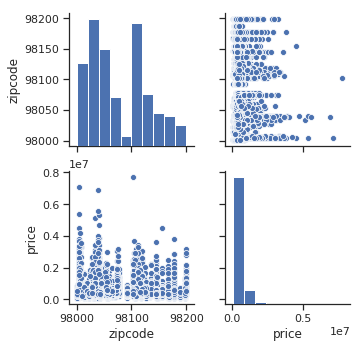

In [76]:
# Let's make a pairplot with seaborn to check the distribution
# and relationship between our dataset. 
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df[['zipcode', 'price']])

### Let's drop the zipcode

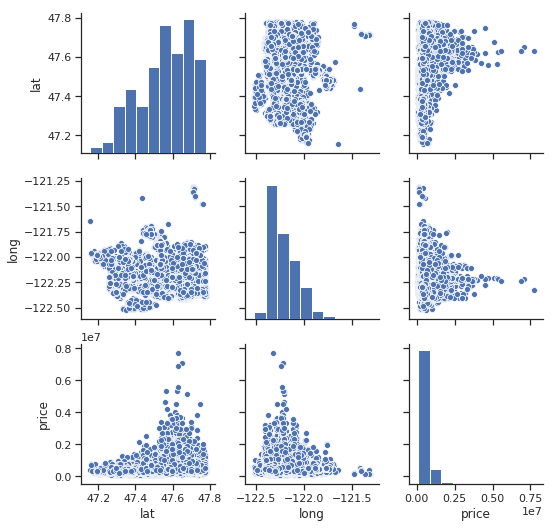

In [77]:
# Let's make a pairplot with seaborn to check the distribution
# and relationship between our dataset. 
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df[['lat', 'long', 'price']])

let's drop lat, long

Also let's drop ID

## Looking for outliers



There is a property with >30 bedrooms! but upon inspection it only has 1.75 bathrooms, and 1620 sq ft of living area, the 33 must be a typo. Remove

In [78]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [79]:
df[df.bedrooms>30]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view      ...       sqft_basement  \
15856      6000     1.0         0.0   0.0      ...                 580   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
15856      1947           0.0    98103  47.6878 -122.331           1330   

       sqft_lot15  is_renovated  has_basement  
15856        4700             0             1  

[1 rows x 23 columns]

In [80]:
df = df[df.bedrooms<30]

# Some questions

## What is the best month / day to sell ?

In [223]:
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

In [224]:
df['year_bought'] = df['date'].apply(lambda x: x.year)
df['month_bought'] = df['date'].apply(lambda x: x.month)
df['dofweek_bought'] = df['date'].apply(lambda x: x.weekday())

In [225]:
sold_per_month = df.groupby('month_bought')['price'].count()
sm = pd.DataFrame(list(sold_per_month),columns=['Nbought'])#.iloc[0]

sold_per_week = df.groupby('dofweek_bought')['price'].count()
sw = pd.DataFrame(list(sold_per_week),columns=['Nbought'])

In [228]:
sm.index

RangeIndex(start=0, stop=12, step=1)

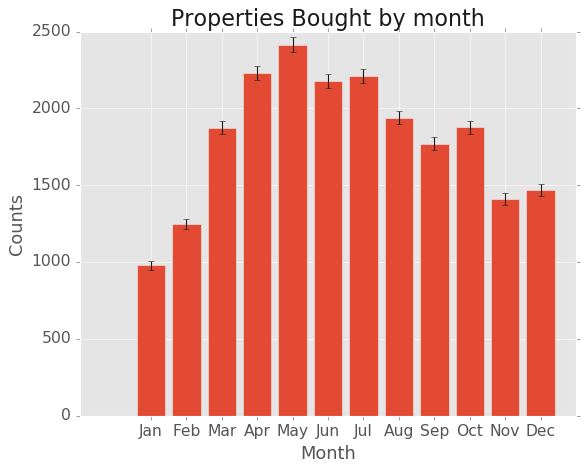

In [245]:

plt.style.use('ggplot')
month_names=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(sm.index, sm.Nbought,yerr = np.sqrt(sm.Nbought)) 
plt.xticks(sm.index,month_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by month',fontsize=20);
plt.xlabel('Month', fontsize=16)
plt.ylabel('Counts',fontsize=16);

In [241]:
day_names=['Mon','Tue', 'Wed', 'Thur','Fri','Sat','Sun']


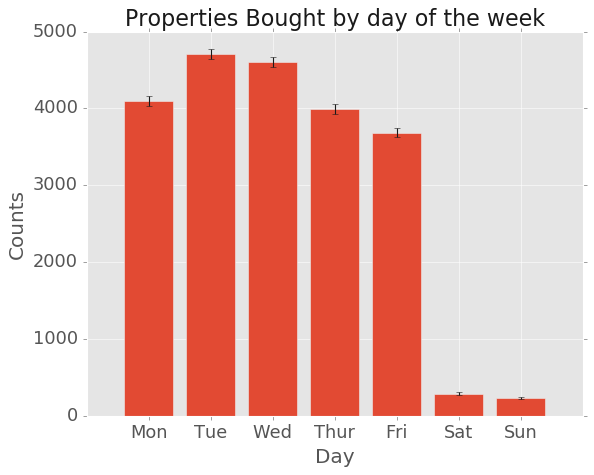

In [244]:
plt.bar(sw.index, sw.Nbought,yerr = np.sqrt(sw.Nbought)) 
plt.xticks(sw.index,day_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by day of the week',fontsize=20);
plt.xlabel('Day', fontsize=18)
plt.ylabel('Counts',fontsize=18);

### Most houses are sold on Tuesdays! Who is buying on a weekend?

## Which are most/least expensive zipcodes

In [250]:
avg_price = (df.groupby('zipcode')['price'].mean())
avg_low = avg_price[:5]
avg_high = avg_price[:-5]

zp_price = pd.DataFrame(avg_price)
zp_price.head()
zp_hi = zp_price.nlargest(4,'price')

zp_lo = zp_price.nsmallest(4,'price')
zipcodes = list(zp_lo.index)
zipcodes += list(zp_hi.index)
five_codes = []
for zp in zipcodes:
    five_codes.append(str(zp))

In [265]:
zp_price.nlargest(4,'price')
print(zp_hi)
zipcodes

                price
zipcode              
98039    2.161300e+06
98004    1.356524e+06
98040    1.194874e+06
98112    1.096239e+06


[98002, 98168, 98032, 98001, 98039, 98004, 98040, 98112]

In [266]:
def ridge(category, data, scale=20):
    return list(zip([category]*len(data), scale*data))

# cats = list(df['zipcode'].unique().astype(str))
cats=five_codes

palette = [cc.rainbow[i*int(256/len(cats))] for i in range(len(cats))]

x = linspace(-10,110, 500)

source = ColumnDataSource(data=dict(x=x))

p = figure(y_range=cats, plot_width=500, plot_height=700, x_range=(0,100), toolbar_location=None)
    
for i, cat in enumerate(reversed(cats)):
    pdf = gaussian_kde((df[df['zipcode']==int(cat)]['price']-df['price'].min())/(df['price'].max()-df['price'].min())*100.0)
    if i<4:
        scale = 8
    else:
        scale = 1
    y = ridge(cat, pdf(x),scale)
    source.add(y, cat)
    p.patch('x', cat, color=palette[i], alpha=0.8, line_color="black", source=source)
    
        
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, 101, 10)))
# p.xaxis.formatter = PrintfTickFormatter(format="%d%%")

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None
p.xaxis.axis_label = '(Price - Min)/(Max - Min) (x100)'
p.yaxis.axis_label = 'ZipCodes'
p.y_range.range_padding = 0.12

show(p,notebook_handle=True);


## LLEW code gos here

In [ ]:
#before we do a linear regeression lets drop some columns

In [102]:
columns_to_drop = ['id', 'zipcode','lat','long','month_bought', 'dofweek_bought', 'waterfront','date','yr_renovated', 'sqft_basement']
# columns_to_drop = [ 'yr_renovated','sqft_basement']
columns_to_drop = [ 'view']
columns_to_drop = [ 'sqft_lot15', 'sqft_living15']


In [103]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [104]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  \
0  221900.0         3       1.00         1180      5650     1.0          3   
1  538000.0         3       2.25         2570      7242     2.0          3   
2  180000.0         2       1.00          770     10000     1.0          3   
3  604000.0         4       3.00         1960      5000     1.0          5   
4  510000.0         3       2.00         1680      8080     1.0          3   

   grade  sqft_above  yr_built  is_renovated  has_basement  year_bought  
0      7        1180      1955             0             0         2014  
1      7        2170      1951             1             1         2014  
2      6         770      1933             0             0         2015  
3      7        1050      1965             0             1         2014  
4      8        1680      1987             0             0         2015

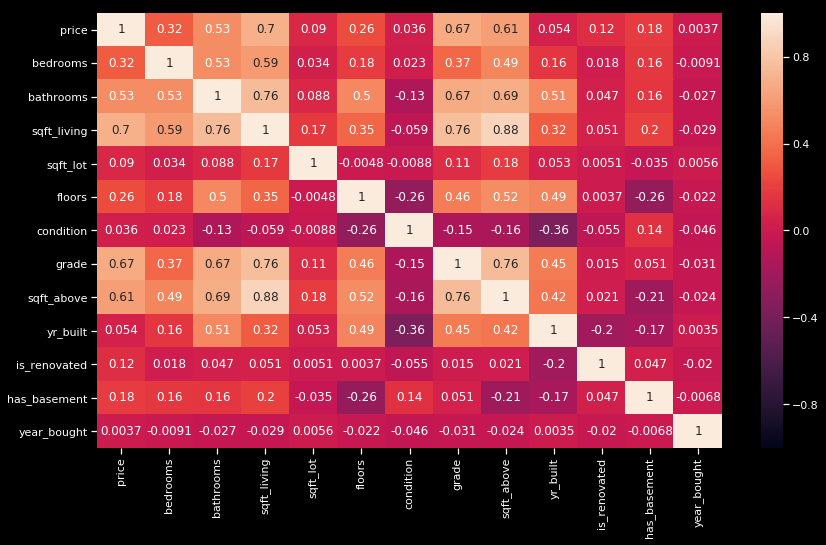

In [105]:
# Let's look at correlations
fig = plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

In [106]:
cat_columns = []
for cols in df.columns:
    if df[cols].nunique()<50:
        cat_columns.append(cols)
        print('Category: {1} \t has {0} Unique values '.format(df[cols].nunique(), cols))
        print('\t\t ',df[cols].unique())
ncat_variables = len(cat_columns)

Category: bedrooms 	 has 11 Unique values 
		  [ 3  2  4  5  1  6  7  8  9 11 10]
Category: bathrooms 	 has 29 Unique values 
		  [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75 6.25
 6.5 ]
Category: floors 	 has 6 Unique values 
		  [1.  2.  1.5 3.  2.5 3.5]
Category: condition 	 has 5 Unique values 
		  [3 5 4 1 2]
Category: grade 	 has 11 Unique values 
		  [ 7  6  8 11  9  5 10 12  4  3 13]
Category: is_renovated 	 has 2 Unique values 
		  [0 1]
Category: has_basement 	 has 2 Unique values 
		  [0 1]
Category: year_bought 	 has 2 Unique values 
		  [2014 2015]


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 13 columns):
price           21596 non-null float64
bedrooms        21596 non-null int64
bathrooms       21596 non-null float64
sqft_living     21596 non-null int64
sqft_lot        21596 non-null int64
floors          21596 non-null float64
condition       21596 non-null int64
grade           21596 non-null int64
sqft_above      21596 non-null int64
yr_built        21596 non-null int64
is_renovated    21596 non-null int64
has_basement    21596 non-null int64
year_bought     21596 non-null int64
dtypes: float64(3), int64(10)
memory usage: 2.3 MB


 ## Let standarize the data

In [171]:
b = df['sqft_living']
df['sqft_living'] = (b-min(b))/(max(b)-min(b))

b = df['sqft_above']
df['sqft_above'] = (b-min(b))/(max(b)-min(b))

b = df['sqft_lot']
df['sqft_lot'] = (b-min(b))/(max(b)-min(b))

b = df['year_bought']
df['year_bought'] = (b-min(b))/(max(b)-min(b))

b = df['yr_built']
df['yr_built'] = (b-min(b))/(max(b)-min(b))

# standardization
b = df['price']
price_mean = np.mean(np.log10(b))
price_var = np.var(np.log10(b))
y = (b-np.mean(b))/(np.sqrt(np.var(b)))


In [162]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  \
0  221900.0         3       1.00     0.061503  0.003108     1.0          3   
1  538000.0         3       2.25     0.167046  0.004072     2.0          3   
2  180000.0         2       1.00     0.030372  0.005743     1.0          3   
3  604000.0         4       3.00     0.120729  0.002714     1.0          5   
4  510000.0         3       2.00     0.099468  0.004579     1.0          3   

   grade  sqft_above  yr_built  is_renovated  has_basement  year_bought  
0      7    0.089602  0.478261             0             0          0.0  
1      7    0.199115  0.443478             1             1          0.0  
2      6    0.044248  0.286957             0             0          1.0  
3      7    0.075221  0.565217             0             1          0.0  
4      8    0.144912  0.756522             0             0          1.0

## Let's split the data into train and test

In [164]:
# y = df['price']
X = df.drop(columns=['price'])

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


## Doing a k-fold on the data

In [118]:
# linreg = LinearRegression()

In [196]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
linreg = linear_model.RidgeCV(alphas=[0.001,0.1, 1., 10], cv=5, fit_intercept=True, scoring=None)

In [197]:
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)


In [198]:
y_hat_test = linreg.predict(X_test)

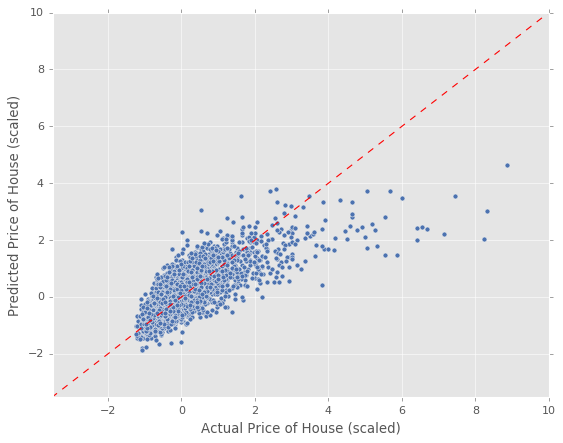

In [184]:
plt.scatter(y_test, linreg.predict(X_test));
plt.plot([-5, 10], [-5, 10], c='red', linestyle='--');

plt.xlim([-3.5,10]);
plt.ylim([-3.5,10]);
plt.xlabel('Actual Price of House (scaled)');
plt.ylabel('Predicted Price of House (scaled)');

In [172]:
def get_price(scaled_price):
    # y = (b-np.mean(b))/(np.sqrt(np.var(b)))
    # (y * np.sqrt(np.var(b))) + np.mean(b) --> b
    return 10**( (scaled_price * np.sqrt(price_var)) + price_mean)

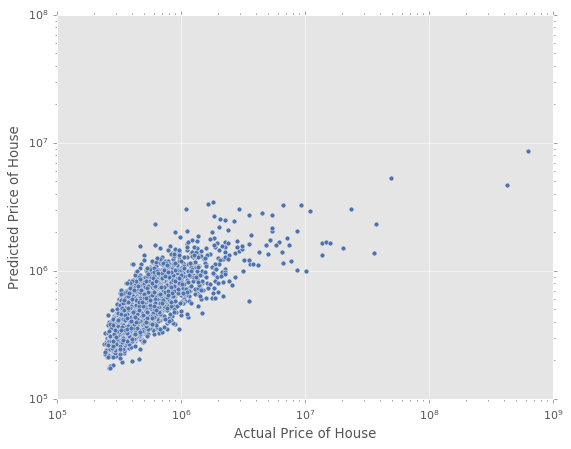

In [181]:
ax = plt.gca()
plt.scatter(list(map(get_price, y_test)), list(map(get_price, linreg.predict(X_test))))
# plt.plot([-5, 10], [-5, 10], c='red', linestyle='--')

# plt.xlim([-3.5,5])
# plt.ylim([-3.5,5e7])
plt.xlabel('Actual Price of House')
plt.ylabel('Predicted Price of House')
ax.set_xscale('log')
ax.set_yscale('log')

In [185]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.3865375587180161
Test Mean Squarred Error: 0.3493206329965961


### We got a model!! Let's inspect if we need all the variables

In [199]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(X_train, y_train)


In [210]:
npred_arr = []
rms_train = []
rms_test=[]
top_predictors = []
for npreds in range(1,len(X_train.columns)):

    selector = RFE(linreg, n_features_to_select = npreds)
    selector = selector.fit(X_train, y_train)
    features_bool = np.array(selector.support_)
    features = np.array(X_train.columns)
    top = features[features_bool]
#     print(top)
#     linreg.fit(X_train, y_train)
    y_hat_train = selector.predict(X_train)
    y_hat_test = selector.predict(X_test)
    
    top_predictors.append(top)
    npred_arr.append(npreds)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    rms_train.append(train_mse)
    rms_test.append(test_mse)

   

In [204]:
linreg

RidgeCV(alphas=array([1.e-03, 1.e-01, 1.e+00, 1.e+01]), cv=5,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

Text(0, 0.5, 'RMSE')

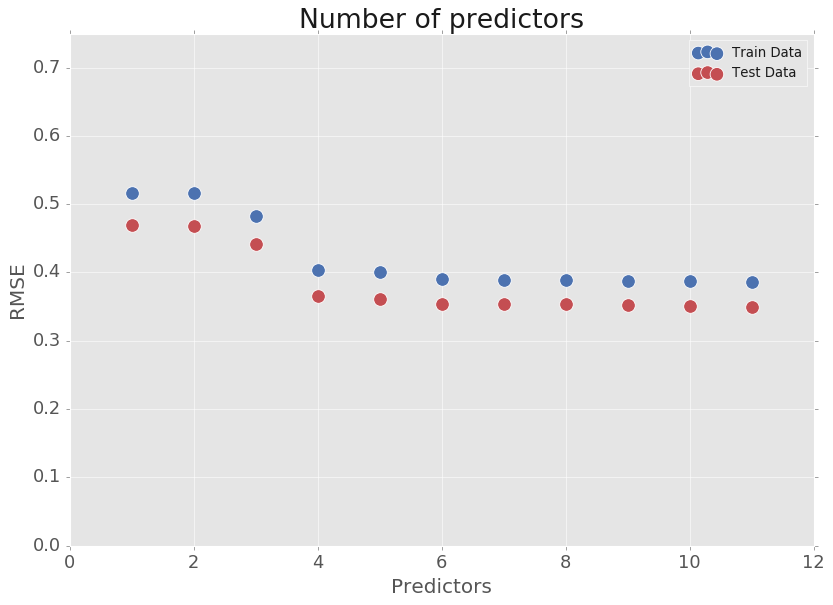

In [209]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(npred_arr, rms_train,label='Train Data',s=150,color='b')
sns.scatterplot(npred_arr, rms_test,label='Test Data',s=150,color='r')
plt.xlabel('Predictors',fontsize=18)
plt.title('Number of predictors',fontsize=24)

# plt.xticks(npred_arr,X_train.columns,rotation='vertical',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.0, 0.75)
plt.ylabel('RMSE', fontsize=18)

In [211]:
print(top_predictors[3])

['sqft_living' 'sqft_lot' 'grade' 'yr_built']
